In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

In [4]:
import torch
from transformers import AutoTokenizer
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from trl.core import respond_to_batch

from pythainlp.corpus import thai_words
import pandas as pd
import numpy as np

In [5]:
device = torch.device("cuda") #ppo_trainer.accelerator.device
device

device(type='cuda')

## Tokenizer

In [6]:
import re

def has_thai_char(string):
    thai_char_regex = '[\u0E00-\u0E7F]+'
    return re.search(thai_char_regex, string) is not None

def has_english_char(string):
    english_char_regex = '[\x00-\x7F]+'
    return re.search(english_char_regex, string) is not None

In [12]:
tokenizer_xglm = AutoTokenizer.from_pretrained('facebook/xglm-564M')
tokenizer_mgpt = AutoTokenizer.from_pretrained('sberbank-ai/mGPT')
tokenizer_gptj = AutoTokenizer.from_pretrained('EleutherAI/gpt-j-6B')
#'EleutherAI/gpt-neox-20b', EleutherAI/gpt-j-6B,'EleutherAI/gpt-neo-2.7B'

In [13]:
#% thai subwords; xglm
thai_toks = [i for i in tokenizer_xglm.vocab if has_thai_char(i)]
len(thai_toks), len(tokenizer_xglm.vocab), len(thai_toks) / len(tokenizer_xglm.vocab)

(4226, 256008, 0.016507296646979783)

In [14]:
#% eng subwords; xglm
eng_toks = [i for i in tokenizer_xglm.vocab if has_english_char(i)]
len(eng_toks), len(tokenizer_xglm.vocab), len(eng_toks) / len(tokenizer_xglm.vocab)

(143413, 256008, 0.5601895253273336)

In [15]:
#% thai subwords; mgpt
thai_toks = [i for i in tokenizer_mgpt.vocab if has_thai_char(i)]
len(thai_toks), len(tokenizer_mgpt.vocab), len(thai_toks) / len(tokenizer_mgpt.vocab)

(0, 100000, 0.0)

In [16]:
#% eng subwords; mgpt
eng_toks = [i for i in tokenizer_mgpt.vocab if has_english_char(i)]
len(eng_toks), len(tokenizer_mgpt.vocab), len(eng_toks) / len(tokenizer_mgpt.vocab)

(65524, 100000, 0.65524)

In [17]:
#% thai subwords; gptj
thai_toks = [i for i in tokenizer_gptj.vocab if has_thai_char(i)]
len(thai_toks), len(tokenizer_gptj.vocab), len(thai_toks) / len(tokenizer_gptj.vocab)

(0, 50400, 0.0)

In [18]:
#% eng subwords; gptj
eng_toks = [i for i in tokenizer_gptj.vocab if has_english_char(i)]
len(eng_toks), len(tokenizer_gptj.vocab), len(eng_toks) / len(tokenizer_gptj.vocab)

(49565, 50400, 0.9834325396825396)

In [19]:
thai_words_df = pd.DataFrame({'thai_word': list(thai_words())})
thai_words_df['xglm_tokens'] = thai_words_df\
    .thai_word.map(lambda x: [tokenizer_xglm.decode(i) for i in tokenizer_xglm.encode(x)])
thai_words_df['xglm_nb_tokens'] = thai_words_df['xglm_tokens'].map(lambda x: len(x))
thai_words_df['mgpt_tokens'] = thai_words_df\
    .thai_word.map(lambda x: [tokenizer_mgpt.decode(i) for i in tokenizer_mgpt.encode(x)])
thai_words_df['mgpt_nb_tokens'] = thai_words_df['mgpt_tokens'].map(lambda x: len(x))
thai_words_df['gptj_tokens'] = thai_words_df\
    .thai_word.map(lambda x: [tokenizer_gptj.decode(i) for i in tokenizer_gptj.encode(x)])
thai_words_df['gptj_nb_tokens'] = thai_words_df['gptj_tokens'].map(lambda x: len(x))

In [20]:
thai_words_df.head(10)

,thai_word,xglm_tokens,xglm_nb_tokens,mgpt_tokens,mgpt_nb_tokens,gptj_tokens,gptj_nb_tokens
0,ชิน คอร์ปอเรชั่น,"[</s>, ช, ิน, , คอร์, ป, อเร, ชั่น]",8,"[ช, ิ, น, ค, อร, ์, ป, อเร, ช, ั่, น]",11,"[�, �, �, �, �, �, , �, �, �, �, �, �, �, �, ...",31
1,การออม,"[</s>, การ, ออ, ม]",4,"[การ, อ, อม]",3,"[�, �, �, �, �, �, �, �, �, �, �, �]",12
2,ความสัตย์,"[</s>, ความ, สัต, ย์]",4,"[ความ, ส, ั, ตย, ์]",5,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, ...",18
3,คอต่อ,"[</s>, , คอ, ต่อ]",4,"[ค, อต, ่, อ]",4,"[�, �, �, �, �, �, �, �, �, �]",10
4,ตีหน้าเซ่อ,"[</s>, , ตี, หน้า, เ, ซ่อ]",6,"[ต, ี, หน, ้, า, เซ, ่, อ]",8,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, ...",20
5,กระหึม,"[</s>, กระ, ห, ึ, ม]",5,"[กระ, ห, ึ, ม]",4,"[�, �, �, �, �, �, �, �, �, �, �, �]",12
6,มัธยมศึกษา,"[</s>, , มั, ธ, ย, มศึกษา]",6,"[ม, ั, ธ, ยม, ศ, ึ, กษา]",7,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, ...",20
7,ลอว์เรนเซียม,"[</s>, , ลอ, ว์, เร, น, เซีย, ม]",8,"[ล, อว, ์, เร, น, เซ, ี, ยม]",8,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, ...",24
8,เอ็คโคไวรัส,"[</s>, เอ, ็ค, โค, ไว, รัส]",6,"[เอ, ็, ค, โค, ไว, ร, ั, ส]",8,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, ...",22
9,คร่ำ,"[</s>, , คร, ่ํา]",4,"[คร, ่, ำ]",3,"[�, �, �, �, �, �, �, �]",8


<AxesSubplot:>

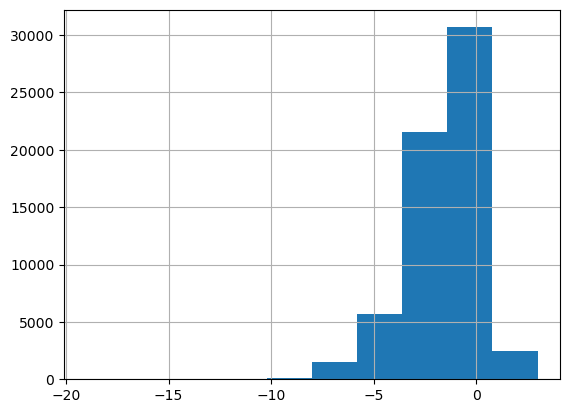

In [22]:
thai_words_df['diff_nb_tokens'] = thai_words_df.xglm_nb_tokens - 1 - thai_words_df.mgpt_nb_tokens
thai_words_df.diff_nb_tokens.hist(bins=10)

In [23]:
#about 80% of the cases xglm tokenizes to fewer tokens
np.percentile(thai_words_df.diff_nb_tokens, np.arange(0, 100, 10))

array([-19.,  -4.,  -3.,  -2.,  -2.,  -1.,  -1.,  -1.,   0.,   0.])

In [ ]:
from datasets import load_dataset

iapp = load_dataset('iapp_wiki_qa_squad')
iapp

In [ ]:
iapp['train'][0]['answers']['text'][0]

In [ ]:
ds = []
for i in iapp['train']:
    ds.append({'concat': f"C: {i['context']} Q:{i['question']} A:{i['answers']['text'][0]}"})
iapp_df = pd.DataFrame(ds)
iapp_df['nb_tokens'] = iapp_df.concat.map(lambda x: len(tokenizer_xglm.encode(x)))

In [ ]:
#90% is less than 573 tokens
np.percentile(iapp_df.nb_tokens, np.arange(0, 100, 10))

In [ ]:
(iapp_df.nb_tokens>512).mean(), iapp_df.shape

In [ ]:
iapp_df['nb_tokens'].hist()

## Few-shot Inferences

In [ ]:
pretrained = 'facebook/xglm-564M'
tokenizer = AutoTokenizer.from_pretrained(pretrained)
model = AutoModelForCausalLMWithValueHead.from_pretrained(pretrained).to(device)
model_ref = create_reference_model(model).to("cuda")

In [ ]:
# initialize trainer
ppo_config = PPOConfig(
    batch_size=1,
    forward_batch_size=1
)
ppo_trainer = PPOTrainer(ppo_config, model, model_ref, tokenizer)

In [ ]:
# encode a query
query_txt = ["Q: ทีมไรเมพสุดในเกาะอังกฤษ A:" for i in range(10)]
query_tensor = tokenizer.encode(query_txt, return_tensors="pt").to(device)

# get model response
response_tensor  = respond_to_batch(model_ref, query_tensor,
                                   txt_len=512, top_k=0, top_p=1.,
                                   end=2)
tokenizer.decode(response_tensor[0])

In [ ]:
# encode a query
query_txt = ["Q: ทีมฟุตบอลทีมไหนเก่งที่สุดในเกาะอังกฤษ? A:" for i in range(10)]
query_tensor = tokenizer(text=query_txt, return_tensors="pt").to(device)

In [11]:
%%time
response_tensor  = respond_to_batch(model_ref, query_tensor['input_ids'],
                                   txt_len=128, top_k=0, top_p=1.)

NameError: name 'model_ref' is not defined

In [200]:
tokenizer.batch_decode(response_tensor)

['แมนเชสเตอร์ยูไนเต็ด ทีมอันดับ 10 แมนฯยูไนเต็ด MOU เปลี่ยนแปลงพรีเมียร์ลีก 2015-16 รอบชิงชนะเลิศ และ รอบชิงชนะเลิศก็ เป็นการต่อสัญญากับทาง ลิเวอร์พูล แล้ว ทีแรกเราก็คิดว่าไม่น่าจะพลาด ได้ลงเล่นแล้ว ก็ต้องขึ้นอยู่กับ แฟนๆ ล้านปอนด์ว่า “เราจะให้มี ลิเวอร์พูล ลงช่วยมากกว่านี้ไหม?”</s> ถามว่า เนื้อเครื่องของเมืองแมนเชสเตอร์ ดูเหมือนจะย่อส่วนลง เพราะแข่งในเอ็นเอสอาร์เอ (เอ็นไควอลได้กว่าฝั่งสิงคโปร์ 400 เท่า) ซึ่งนายจ้างกําลังเพิกเฉยต่อ เลยพยายามทําให้เดอะค',
 'ปีก่อนแข่งในรอบแรก</s> Q: หลังจากกําเนิดสโมสรฟุตบอลยุค 90 ทีมฟุตบอลไทยประสบความสําเร็จจนฉ</s> Q: งานแต่งกับลีโอนาร์โด้ ทายาทโอเรียนท์ในประเทศอิตาลี A: หลังจากสารพั</s> Q: การปรับตัวของรัฐบาลในอังกฤษหลังการไฟไหม้ประตูไฟไหม้ทางสโมสร A</s> Q: อีกมุมหนึ่งของประวัติศาสตร์ฟุตบอลอังกฤษ A: ในปี 1978 สโมสรฟุตบอล</s> Q: นักเตะเจ้าของสโมสรฟุตบอลในประเทศอังกฤษ A: ผมจะลองกล่าวอะไรกับท่าน</s> Q: นักโทษเยาวชนอายุ 16-18 ปีในประเทศอังกฤษคือใคร? A: นักเตะฟุตบอล ที</s>',
 'ทีมฟุตบอลจากสโมสรฮอนธิกรลีก : อยู่แชมเปี้ยนลีก์. Netherlands Premier League : นิ

In [203]:
from datasets import Dataset

# Define the file path
all_df = pd.read_csv('../data_large/all_df.csv')

# # Create a Hugging Face dataset from the list of lines
# dataset = Dataset.from_dict({"text": lines})

In [204]:
all_df[['title','body','']]

,datasource_url_x,content_id,type_x,title,body,total_field,tags,like_score_x,feel_heart_x,feel_laugh_x,...,type_y,comment,like_score_y,feel_heart_y,feel_laugh_y,feel_love_y,feel_sad_y,feel_horror_y,feel_wow_y,nb_interact
0,https://pantip.com/topic/36188003,36188003,content,ส่งDMในทวิตไม่ได้ ทำยังไงดี?,DMในทวิตไม่ได้ค่ะ พอส่งมันก็ขึ้นว่า การดำเนินก...,4,"Social Network,Twitter",0,0,0,...,comment,ส่งหาใครคะ ดีเอ็มต้องโฟโลทั้งสองฝ่ายปะอะ,0,0,0,0,0,0,0,0
1,https://pantip.com/topic/36188003,36188003,content,ส่งDMในทวิตไม่ได้ ทำยังไงดี?,DMในทวิตไม่ได้ค่ะ พอส่งมันก็ขึ้นว่า การดำเนินก...,4,"Social Network,Twitter",0,0,0,...,comment,ไม่ต้อง follow กันและกัน ก็ส่งได้นะส่งมาแล้วแต...,0,0,0,0,0,0,0,0
2,https://pantip.com/topic/36188003,36188003,content,ส่งDMในทวิตไม่ได้ ทำยังไงดี?,DMในทวิตไม่ได้ค่ะ พอส่งมันก็ขึ้นว่า การดำเนินก...,4,"Social Network,Twitter",0,0,0,...,comment,จขกท.แก้ได้ยังค่ะ เราก็เปน ฝากด้วยนะคะ(แต่เราส...,0,0,0,0,0,0,0,0
3,https://pantip.com/topic/36188003,36188003,content,ส่งDMในทวิตไม่ได้ ทำยังไงดี?,DMในทวิตไม่ได้ค่ะ พอส่งมันก็ขึ้นว่า การดำเนินก...,4,"Social Network,Twitter",0,0,0,...,comment,แก้ได้ยังคะ?เราก็เป็น,0,0,0,0,0,0,0,0
4,https://pantip.com/topic/36188206,36188206,content,ใช้เน็ตบ้านทรูขึ้น ERR_CONNECTION_RESET บ่อยม...,ใช้เน็ตบ้านทรูขึ้น ERR_CONNECTION_RESET บ่อยม...,3,"อินเทอร์เน็ต,ADSL,Network,true online,Wi-Fi",0,0,0,...,comment,ไม่ไหว เบื่อ ที่เรียกซ่อม,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11403905,https://pantip.com/topic/31113669,31113669,content,เคยมีสโมสร ลาลีกา spain ไปเตะที่หมู่เกาะ canar...,หมู่เกาะ canary เกาะ medeira จะอยู่ใกล้ทวีป af...,7,"ฟุตบอล,ฟุตบอลต่างประเทศ",0,0,0,...,comment,ทีม Nacional ไง ทีมเก่าของเจ็ทโด้ก่อนย้ายไปปอร...,0,2,0,0,0,0,0,2
11403906,https://pantip.com/topic/31113669,31113669,content,เคยมีสโมสร ลาลีกา spain ไปเตะที่หมู่เกาะ canar...,หมู่เกาะ canary เกาะ medeira จะอยู่ใกล้ทวีป af...,7,"ฟุตบอล,ฟุตบอลต่างประเทศ",0,0,0,...,comment,อีกทีมบนเกาะ Madeira ก็คือทีม Maritimo ครับ ถ้...,0,1,0,0,0,0,0,1
11403907,https://pantip.com/topic/31113669,31113669,content,เคยมีสโมสร ลาลีกา spain ไปเตะที่หมู่เกาะ canar...,หมู่เกาะ canary เกาะ medeira จะอยู่ใกล้ทวีป af...,7,"ฟุตบอล,ฟุตบอลต่างประเทศ",0,0,0,...,comment,เกาะมาร์ยอก้า - รีล มาร์ยอก้าเกาะคอร์ซิก้า - A...,0,0,0,0,0,0,0,0
11403908,https://pantip.com/topic/31113669,31113669,content,เคยมีสโมสร ลาลีกา spain ไปเตะที่หมู่เกาะ canar...,หมู่เกาะ canary เกาะ medeira จะอยู่ใกล้ทวีป af...,7,"ฟุตบอล,ฟุตบอลต่างประเทศ",0,0,0,...,comment,เจลีก เกาะทั้งประเทศยังเตะกันได้เลยครัช บาง...,0,0,0,0,0,0,0,0
